In [1]:
from Bio import SeqIO
genome_dict = SeqIO.to_dict(SeqIO.parse("IRGSP-1.0_genome.fasta", "fasta"))
#wget https://rapdb.dna.affrc.go.jp/download/archive/irgsp1/kasalath_genome.tar.gz

In [66]:
seq_check = str(genome_dict["chr09"].seq[15242482-1:15242482+2400])
chunk_size = 240

# 切分序列并生成变量名
for i in range(0, len(seq_check), chunk_size):
    chunk = seq_check[i:i+chunk_size]
    globals()[f"seq_check_{i // chunk_size + 1}"] = chunk
    print(globals()[f"seq_check_{i // chunk_size + 1}"])

GAAGCAGAATGGTGAGTGGGGCGGCTTTTATAGGAATCAATTGGGCCGCGTGACCAGCTAATGATATAGAGATTAATGGCTGATTTGTTCTCAGTTTCTCACACACTCGTCGCGTTTGCAATGATTTGCTTAGAGGCAAAGGAAAAACGAAGCGTCACATTAACGTGCAAAAAGGAAATAATTGTCGTTTAATTCAGACTCATCGTAATAGGGAAAGCGAATACTCCACATTGGAGATTA
CGGCTGGTTCACTGTTTCATACTACTCCAGTACTAGCACTAGTAGCGTCGGTCAAATTACTAGTGCTAGCGATATCCGCATTGGAAATCTTCGAATACGTGGCCGGTAATTAAGACACTGGGAAGAACTAGAGGTGGTTGCTTTCAATGAAGCGGCGGGGATACCGGTCAAACTTTTGTActctctctatctattttttgatagttatatttttaaatctaaaaattttatttttgatag
aaatatttcaatccaacaaactattcccttaatgactttttcggatttaatgcgtgactctccattcttccacacatgattggctatatggacattgaaaaatgtaaatattaatgaattgcttgtttacgatgaatgagtagtaacatatttaaatgaatgataagtagaattatttatcattggtctgtgtgtcaagataaaatgactatcaaaagtagatgtaaggagTACTACATA
GTCTACATGTGGACAATGCAAAAGAGAAAAGTTAAGGgcccatttcattcaaatgaaattcatataaattttagaggatctcatttctataggaatttttcctatatagccctttgaatcaaatgaatagatgctataaaatccaatgaaattcctatggaatgcttaatactccatgcaagttttagaggaattctaacttgaggtagaacctcatggaaactttccgtcgagtcttta
tctctcttctaattcctgcgtttttcctgtggtcca

In [68]:
nucleotides = ['A', 'C', 'G', 'T']
mutated_sequences_dict = {}

# 遍历序列中的每个位置
for i, original_base in enumerate(seq_check_1):
    # 对于当前位置，将其替换为除了自身之外的其它三个碱基
    for nt in nucleotides:
            # 生成新的序列
        new_sequence = seq_check_1[:i] + nt + seq_check_1[i+1:]
            # 构建键，格式为“位置_突变”
        key = f"{i+1}_{nt}"
            # 将键值对添加到字典中
        mutated_sequences_dict[key] = new_sequence
            #print(f"键: {key}，突变序列: {new_sequence}")

In [69]:
import torch
import torch.nn.functional as F

# one-hot 编码函数
def one_hot_encode(sequence, alphabet='ACGT'):
    """Convert DNA sequence to one-hot encoding."""
    mapping = {nucleotide: i for i, nucleotide in enumerate(alphabet)}
    seq_encoded = torch.zeros(len(alphabet), len(sequence))
    for i, nucleotide in enumerate(sequence):
        if nucleotide in mapping:
            seq_encoded[mapping[nucleotide], i] = 1
    return seq_encoded 

# 定义最大序列长度
max_len = 240

# 假设 mutated_sequences_dict 已经生成，其结构为 {键: 序列字符串}
# 示例：
# mutated_sequences_dict = {
#     '1_C': 'CACACGAGTTT...',
#     '1_G': 'GACACGAGTTT...',
#      ...
# }

# 构建新的字典，键与 mutated_sequences_dict 保持一致，
# 值为对应的 one-hot 编码后并 padding 到 max_len 的特征序列
padded_sequences_dict = {}
for key, seq in mutated_sequences_dict.items():
    # 对序列进行 one-hot 编码
    one_hot = one_hot_encode(seq)
    # 计算需要 padding 的大小
    pad_size = max_len - one_hot.size(1)
    # 使用 F.pad 进行 padding，pad 参数表示在序列维度（最后一维）右侧补齐 pad_size 个 0
    padded = F.pad(one_hot, (0, pad_size))
    padded_sequences_dict[key] = padded
    #print(f"键：{key} 对应的特征序列 shape：{padded.shape}")
    

# 现在 padded_sequences_dict 中每个键对应的值都是 shape 为 [4, 240] 的特征序列张量

In [182]:
import torch
import torch.nn.functional as F
import lightning.pytorch as pl

import torch
import torch.nn as nn
import lightning.pytorch as pl
import matplotlib.pyplot as plt

# 定义带归一化及激活的卷积层
class Conv1dNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, batch_norm=True, weight_norm=False):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=not weight_norm)
        if weight_norm:
            self.conv = nn.utils.weight_norm(self.conv)
        self.bn = nn.BatchNorm1d(out_channels) if batch_norm else None
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.conv(x)
        if self.bn:
            x = self.bn(x)
        return self.activation(x)

# 定义带归一化及激活的全连接层
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features, batch_norm=True, weight_norm=False):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias=not weight_norm)
        if weight_norm:
            self.linear = nn.utils.weight_norm(self.linear)
        self.bn = nn.BatchNorm1d(out_features) if batch_norm else None
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.linear(x)
        if self.bn:
            x = self.bn(x)
        return self.activation(x)

# 定义完整的 ConvNet 模型
class ConvNet(pl.LightningModule):
    def __init__(self, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        
        self.conv1 = Conv1dNorm(4, 300, 19, padding=9)
        self.conv2 = Conv1dNorm(300, 200, 11, padding=5)
        self.conv3 = Conv1dNorm(200, 200, 7, padding=3)
        
        self.pool = nn.MaxPool1d(3)
        self.flatten = nn.Flatten()
        
        # 假设原始序列长度为 240，计算经过3次 Conv+Pool 后的长度
        seq_len = 240
        seq_len = (seq_len - 19 + 2*9 + 1) // 3  # Conv1 + Pool
        seq_len = (seq_len - 11 + 2*5 + 1) // 3   # Conv2 + Pool
        seq_len = (seq_len - 7 + 2*3 + 1) // 3    # Conv3 + Pool
        fc_input_dim = 200 * seq_len

        self.fc1 = LinearNorm(fc_input_dim, 1000)
        self.fc2 = nn.Linear(1000, 2)
        
        self.dropout = nn.Dropout(p=0.3)
        self.criterion = nn.CrossEntropyLoss()
        self.activation = nn.ReLU()
    
    def encode(self, x):
        x = self.activation(self.conv1(x))
        x = self.pool(x)
        x = self.activation(self.conv2(x))
        x = self.pool(x)
        x = self.activation(self.conv3(x))
        x = self.pool(x)
        x = self.flatten(x)
        return x
    
    def decode(self, x):
        x = self.dropout(self.activation(self.fc1(x)))
        x = self.fc2(x)
        return x
    
    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

# 假设 ConvNet 类已正确定义，并实现 forward 方法
# 从检查点加载模型
model = ConvNet.load_from_checkpoint("model_checkpoint_earlystop_100_ACGT.ckpt")
model.eval() 

ConvNet(
  (conv1): Conv1dNorm(
    (conv): Conv1d(4, 300, kernel_size=(19,), stride=(1,), padding=(9,))
    (bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (conv2): Conv1dNorm(
    (conv): Conv1d(300, 200, kernel_size=(11,), stride=(1,), padding=(5,))
    (bn): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (conv3): Conv1dNorm(
    (conv): Conv1d(200, 200, kernel_size=(7,), stride=(1,), padding=(3,))
    (bn): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (pool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): LinearNorm(
    (linear): Linear(in_features=1600, out_features=1000, bias=True)
    (bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  

In [183]:
scores_dict = {}  # 用于保存每个序列对应的打分

# 禁用梯度计算，提升推理效率
with torch.no_grad():
    for key, padded_seq in padded_sequences_dict.items():
        # 增加批次维度：原始张量 shape [4, 240] -> [1, 4, 240]
        input_tensor = padded_seq.unsqueeze(0)
        # 将输入传给模型得到输出得分，具体输出形式取决于模型设计
        score = model(input_tensor)
        # 如果模型输出为单个数值，可以使用 score.item() 提取标量
        # 此处假设 score 为张量
        probabilities = F.softmax(score, dim=1)
        scores_dict[key] = probabilities
        #print(f"键: {key}, 得分: {score}")

In [184]:
padded_seq.shape

torch.Size([4, 240])

In [185]:
padded.shape

torch.Size([1, 4, 240])

In [186]:
def predict_probability(seq_check_1):
    x = seq_check_1
    x = one_hot_encode(x, alphabet='ACGT')
    max_len = 240
    pad_size = max_len - x.size(1)
    padded = F.pad(x, (0, pad_size))
    padded = padded.unsqueeze(0)
    outputs = model(padded)
    probabilities = F.softmax(outputs, dim=1)
    probabilities = probabilities[0,1].item()
    return probabilities

In [187]:
predict_probability(seq_check_2)

0.49272099137306213

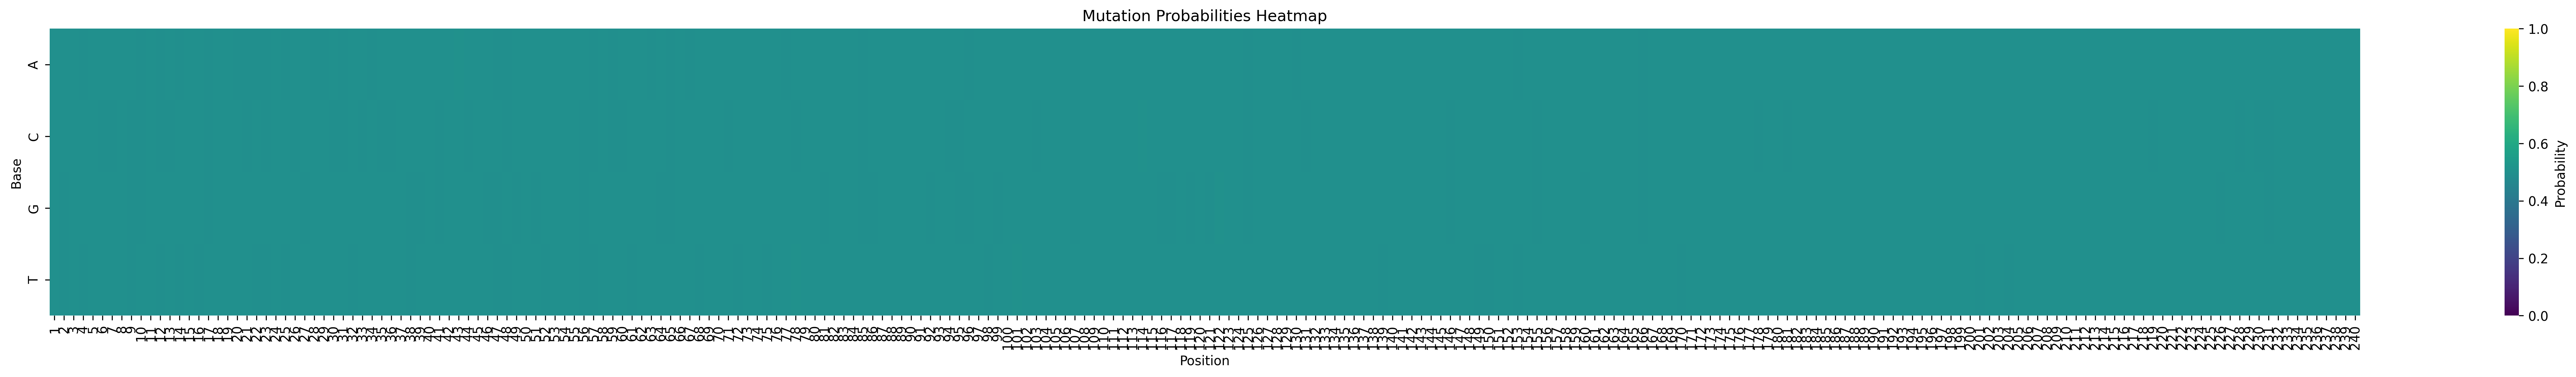

In [188]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# 初始化一个字典，用于存储位置和碱基对应的概率值
data_dict = {}

# 遍历 scores_dict，解析键并提取概率值
for key, tensor in scores_dict.items():
    position, base = key.split('_')
    position = int(position)  # 将位置转换为整数
    # 假设我们关注第二个概率值（索引为1）
    probability = tensor[0, 1].item()
    if position not in data_dict:
        data_dict[position] = {}
    data_dict[position][base] = probability

# 获取所有的位置和碱基类型
positions = sorted(data_dict.keys())
bases = ['A', 'C', 'G', 'T']

# 构建数据矩阵
heatmap_data = np.zeros((len(bases), len(positions)))

for col, position in enumerate(positions):
    for row, base in enumerate(bases):
        heatmap_data[row, col] = data_dict[position].get(base, np.nan)  # 使用 np.nan 处理缺失值

# 绘制热图
plt.figure(figsize=(40, 4),dpi=300)
sns.heatmap(heatmap_data, annot=False, cmap='viridis', vmin=0, vmax=1,
            xticklabels=positions, yticklabels=bases, cbar_kws={'label': 'Probability'})

plt.xlabel('Position')
plt.ylabel('Base')
plt.title('Mutation Probabilities Heatmap')
#plt.savefig("chr02_1560.png")
plt.show()


In [288]:
import random
import torch  # 这里假设你的模型使用 PyTorch 张量

def heuristic_mutation(seq, max_len=240, alphabet='ACGT', 
                       num_mutations_range=(4,5), num_trials=500):
    """
    对DNA序列 seq 进行启发式突变：
      - 每次随机选定 3 到 5 个位点进行突变（突变位置由 num_mutations_range 决定）
      - 对每一次突变，替换的碱基在给定字母表中选择（不等于原碱基）
      - 利用打分函数 predict_probability(seq, model, max_len, alphabet)
        对候选突变后的序列进行评分
      - 重复 num_trials 次，最后返回评分最高的突变序列以及其预测得分

    参数：
      seq: 原始DNA序列（字符串）
      model: 预测概率的模型（作为 predict_probability() 的参数传入）
      max_len: predict_probability() 的参数，默认240
      alphabet: 碱基表，默认为 'AGCT'
      num_mutations_range: 突变位点数量范围（元组），默认(3,5)
      num_trials: 尝试候选次数，默认50

    返回：
      best_seq: 得分最高的变异序列（字符串）
      best_score: 此序列对应的预测得分（浮点数）
    """
    best_seq = seq
    best_score = predict_probability(seq)
    
    num_mutations = random.randint(num_mutations_range[0], num_mutations_range[1])
    print(num_mutations)
    
    for _ in range(num_trials):
        # 将序列转换为列表，便于逐字符修改
        candidate = list(seq)
        # 随机选择 num_mutations 个不同的位置进行突变
        indices = random.sample(range(len(candidate)), num_mutations)
        # 对选中的每个位点，替换为字母表中除原字符以外的随机碱基
        for idx in indices:
            orig_char = candidate[idx]
            alternatives = [c for c in alphabet if c != orig_char]
            candidate[idx] = random.choice(alternatives)
        candidate_seq = ''.join(candidate)
        # 计算候选序列的得分，并转换为标量
        candidate_score = predict_probability(candidate_seq)
        # 如果候选序列得分更高，则更新最优序列
        if candidate_score > best_score:
            best_seq = candidate_seq
            best_score = candidate_score
    
    return best_seq, best_score

In [312]:
def heuristic_mutation(seq, max_len=240, alphabet='ACGT',
                       num_mutations_range=(4,5), num_trials=500):
    best_seq = seq
    best_score = predict_probability(seq)
    
    # determine number of mutations
    num_mutations = random.randint(num_mutations_range[0], num_mutations_range[1])
    print(f"Mutating a contiguous block of length: {num_mutations}")
    
    for _ in range(num_trials):
        # choose a random start for contiguous block
        start = random.randint(0, len(seq) - num_mutations)
        # convert seq to list for mutation
        candidate = list(seq)
        # apply mutations in the contiguous block [start, start + num_mutations)
        for idx in range(start, start + num_mutations):
            orig_char = candidate[idx]
            # choose a base different from the original
            alternatives = [c for c in alphabet if c != orig_char]
            candidate[idx] = random.choice(alternatives)
        candidate_seq = ''.join(candidate)
        
        # evaluate and update best
        candidate_score = predict_probability(candidate_seq)
        if candidate_score > best_score:
            best_seq = candidate_seq
            best_score = candidate_score
    
    return best_seq, best_score

In [247]:
import random

def genetic_algorithm(seq, 
                      pop_size=100, 
                      num_generations=1000,
                      crossover_rate=0.7, 
                      mutation_rate=0.01,
                      alphabet='ACGT'):
    # 1. 初始化种群
    population = [''.join(random.choices(alphabet, k=len(seq)))
                  for _ in range(pop_size)]
    # 可选：将原始序列加入种群
    population[0] = seq

    for gen in range(num_generations):
        # 2. 计算适应度
        fitness = [predict_probability(ind) for ind in population]
        
        # 3. 选择（锦标赛选择示例）
        def select_one():
            a, b = random.sample(range(pop_size), 2)
            return population[a] if fitness[a] > fitness[b] else population[b]
        
        # 4. 交叉与 5. 变异 生成新种群
        new_pop = []
        while len(new_pop) < pop_size:
            parent1 = select_one()
            parent2 = select_one()
            # 交叉
            if random.random() < crossover_rate:
                pt = random.randint(1, len(seq)-1)
                child1 = parent1[:pt] + parent2[pt:]
                child2 = parent2[:pt] + parent1[pt:]
            else:
                child1, child2 = parent1, parent2
            # 变异（位翻转）
            def mutate(ind):
                ind_list = list(ind)
                for i in range(len(ind_list)):
                    if random.random() < mutation_rate:
                        alternatives = [c for c in alphabet if c != ind_list[i]]
                        ind_list[i] = random.choice(alternatives)
                return ''.join(ind_list)
            new_pop.extend([mutate(child1), mutate(child2)])
        
        # 6. 精英保存（保留上代最优个体）
        best_idx = fitness.index(max(fitness))
        new_pop[0] = population[best_idx]
        
        population = new_pop[:pop_size]

    # 返回最终种群中适应度最高的个体
    final_fitness = [predict_probability(ind) for ind in population]
    best_idx = final_fitness.index(max(final_fitness))
    return population[best_idx], final_fitness[best_idx]


In [248]:
# 示例调用
if __name__ == "__main__":
    original_seq = seq_check_1
    # 这里 model 可以替换为你实际使用的模型；本示例中置为 None
    mutated_seq, score = genetic_algorithm(original_seq)
    print("原始序列:", original_seq)
    print("原始得分:", predict_probability(original_seq))
    print("突变序列:", mutated_seq)
    print("预测得分:", score)
    seq_check_1_val = [0.5024,0.9825084805488586]

原始序列: GAAGCAGAATGGTGAGTGGGGCGGCTTTTATAGGAATCAATTGGGCCGCGTGACCAGCTAATGATATAGAGATTAATGGCTGATTTGTTCTCAGTTTCTCACACACTCGTCGCGTTTGCAATGATTTGCTTAGAGGCAAAGGAAAAACGAAGCGTCACATTAACGTGCAAAAAGGAAATAATTGTCGTTTAATTCAGACTCATCGTAATAGGGAAAGCGAATACTCCACATTGGAGATTA
原始得分: 0.49676740169525146
突变序列: CACTCCTAGATGCGTTCGTCTCAACTCTGGGACCGGCAGCCCCATGCACTTCGGGAAGATCTAGAAATACTAGTGCATACCTGATTTAGCGTGTACGTGTTAAGCCGTACCCGTCGAATCGAGACCCTACCATGCTAAGTGTTCAGAACTCCTGACTCACCTCCCCCCCTGTATCTTTGCTTTAGGCTTACGGTATGCATTCTAGATCACTATACATTGACACGTGATAGCAGGTACAGG
预测得分: 0.9997105002403259


In [313]:
# 示例调用
if __name__ == "__main__":
    original_seq = seq_check_1
    # 这里 model 可以替换为你实际使用的模型；本示例中置为 None
    mutated_seq, score = heuristic_mutation(original_seq)
    print("原始序列:", original_seq)
    print("原始得分:", predict_probability(original_seq))
    print("突变序列:", mutated_seq)
    print("预测得分:", score)
    seq_check_1_val = [predict_probability(original_seq),score]

Mutating a contiguous block of length: 5
原始序列: GAAGCAGAATGGTGAGTGGGGCGGCTTTTATAGGAATCAATTGGGCCGCGTGACCAGCTAATGATATAGAGATTAATGGCTGATTTGTTCTCAGTTTCTCACACACTCGTCGCGTTTGCAATGATTTGCTTAGAGGCAAAGGAAAAACGAAGCGTCACATTAACGTGCAAAAAGGAAATAATTGTCGTTTAATTCAGACTCATCGTAATAGGGAAAGCGAATACTCCACATTGGAGATTA
原始得分: 0.49676740169525146
突变序列: GAAGCAGAATGGTGAGTGGGGCGGCTTTTATAGGAATCAATTGGGCCGCGTGACCAGCTAATGATATAGAGATTAATGGCTGATTTGTTCTCAGTTTCTCACACACTCGTATACATTGCAATGATTTGCTTAGAGGCAAAGGAAAAACGAAGCGTCACATTAACGTGCAAAAAGGAAATAATTGTCGTTTAATTCAGACTCATCGTAATAGGGAAAGCGAATACTCCACATTGGAGATTA
预测得分: 0.5045210719108582


In [314]:
# 示例调用
if __name__ == "__main__":
    original_seq = seq_check_2
    # 这里 model 可以替换为你实际使用的模型；本示例中置为 None
    mutated_seq, score = heuristic_mutation(original_seq)
    print("原始序列:", original_seq)
    print("原始得分:", predict_probability(original_seq))
    print("突变序列:", mutated_seq)
    print("预测得分:", score)
    seq_check_2_val = [predict_probability(original_seq),score]

Mutating a contiguous block of length: 5
原始序列: CGGCTGGTTCACTGTTTCATACTACTCCAGTACTAGCACTAGTAGCGTCGGTCAAATTACTAGTGCTAGCGATATCCGCATTGGAAATCTTCGAATACGTGGCCGGTAATTAAGACACTGGGAAGAACTAGAGGTGGTTGCTTTCAATGAAGCGGCGGGGATACCGGTCAAACTTTTGTActctctctatctattttttgatagttatatttttaaatctaaaaattttatttttgatag
原始得分: 0.49272099137306213
突变序列: CGGCTGGTTCACTGTTTCATACTACTCCAGTACTAGCACTAGTAGCGTCGGTCAAATTACTAGTGCTAGCGATATCCGCATTGGAAATCTTCGAATACGTGGCCGGTAATTAAGACACTGGGAAGAACTAGAGGTGGTTGCTTTCAATAGCTGGGCGGGGATACCGGTCAAACTTTTGTActctctctatctattttttgatagttatatttttaaatctaaaaattttatttttgatag
预测得分: 0.50337815284729


In [315]:
# 示例调用
if __name__ == "__main__":
    original_seq = seq_check_3
    # 这里 model 可以替换为你实际使用的模型；本示例中置为 None
    mutated_seq, score = heuristic_mutation(original_seq)
    print("原始序列:", original_seq)
    print("原始得分:", predict_probability(original_seq))
    print("突变序列:", mutated_seq)
    print("预测得分:", score)
    seq_check_3_val = [predict_probability(original_seq),score]

Mutating a contiguous block of length: 4
原始序列: aaatatttcaatccaacaaactattcccttaatgactttttcggatttaatgcgtgactctccattcttccacacatgattggctatatggacattgaaaaatgtaaatattaatgaattgcttgtttacgatgaatgagtagtaacatatttaaatgaatgataagtagaattatttatcattggtctgtgtgtcaagataaaatgactatcaaaagtagatgtaaggagTACTACATA
原始得分: 0.9989604949951172
突变序列: aaatatttcaatccaacaaactattcccttaatgactttttcggatttaatgcgtgactctccattcttccacacatgattggctatatggacattgaaaaatgtaaatattaatgaattgcttgtttacgatgaatgagtagtaaCTTAtttaaatgaatgataagtagaattatttatcattggtctgtgtgtcaagataaaatgactatcaaaagtagatgtaaggagTACTACATA
预测得分: 0.9999270439147949


In [316]:
# 示例调用
if __name__ == "__main__":
    original_seq = seq_check_4
    # 这里 model 可以替换为你实际使用的模型；本示例中置为 None
    mutated_seq, score = heuristic_mutation(original_seq)
    print("原始序列:", original_seq)
    print("原始得分:", predict_probability(original_seq))
    print("突变序列:", mutated_seq)
    print("预测得分:", score)
    seq_check_4_val = [predict_probability(original_seq),score]

Mutating a contiguous block of length: 4
原始序列: GTCTACATGTGGACAATGCAAAAGAGAAAAGTTAAGGgcccatttcattcaaatgaaattcatataaattttagaggatctcatttctataggaatttttcctatatagccctttgaatcaaatgaatagatgctataaaatccaatgaaattcctatggaatgcttaatactccatgcaagttttagaggaattctaacttgaggtagaacctcatggaaactttccgtcgagtcttta
原始得分: 0.9986959099769592
突变序列: GTCTACATGTGGACAATGCAAAAGAGAAAAGTTAAGGgcccatttcattcaaatgaaattcatataaattttagaggatctcatttctataggaatttttcctatatagccctttgaatcaaatgaatagatgctataaATATcaatgaaattcctatggaatgcttaatactccatgcaagttttagaggaattctaacttgaggtagaacctcatggaaactttccgtcgagtcttta
预测得分: 0.9998800754547119


In [317]:
# 示例调用
if __name__ == "__main__":
    original_seq = seq_check_5
    # 这里 model 可以替换为你实际使用的模型；本示例中置为 None
    mutated_seq, score = heuristic_mutation(original_seq)
    print("原始序列:", original_seq)
    print("原始得分:", predict_probability(original_seq))
    print("突变序列:", mutated_seq)
    print("预测得分:", score)
    seq_check_5_val = [predict_probability(original_seq),score]

Mutating a contiguous block of length: 5
原始序列: tctctcttctaattcctgcgtttttcctgtggtccaatcaaacggtcattcctgtgtttttgcaatcatctgttttatacttacatttctattaaaatcctacgttttttttctattcctacgttttttcaattctacgatttaaagggtccCTAAGTTTTTTTTAGAAAACATAAATTTACATGTGTAAAACAAATAATCCTAGATAATAATCCGTTGTCCAAAAAGAGCTAAAACTGT
原始得分: 0.9284871220588684
突变序列: tctctcttctaattcctgcgtttttcctgtggtccaatcaaacggtcattcctgtgtttttgcaatcatctgttttatacttacatttctattaaaatcctacgttttttttctattcctacgtttGCTCTattctacgatttaaagggtccCTAAGTTTTTTTTAGAAAACATAAATTTACATGTGTAAAACAAATAATCCTAGATAATAATCCGTTGTCCAAAAAGAGCTAAAACTGT
预测得分: 0.9423984289169312


In [318]:
# 示例调用
if __name__ == "__main__":
    original_seq = seq_check_6
    # 这里 model 可以替换为你实际使用的模型；本示例中置为 None
    mutated_seq, score = heuristic_mutation(original_seq)
    print("原始序列:", original_seq)
    print("原始得分:", predict_probability(original_seq))
    print("突变序列:", mutated_seq)
    print("预测得分:", score)
    seq_check_6_val = [predict_probability(original_seq),score]

Mutating a contiguous block of length: 5
原始序列: AGCAAGGTGCCTTGGAGGATGGCCTAGAGGCCGTAACTAAATTTGAAATGTTTGAGCAAAtcctatatacttagaggatgcgttcgggaggaggaacccctcctccccggcaagcaaaacgaagcactattgcatttaaattaagtattaactatttttttttgaaaaatagattaatatggttttttaaaacaacttttgtatataaatttttgctaagataacTTATGCTAAGATTTG
原始得分: 0.6556699275970459
突变序列: AGCAAGGTGCCTTGGAGGATGGCCTAGAGGCCGTAACTAAATTTGAAATGTTTGAGCAAAtcctatatacttagaggatgcgttcgggaggaggaacccctcctccccggcaagcaaaacgaagcactattgcatttaaattaagtTTTCActatttttttttgaaaaatagattaatatggttttttaaaacaacttttgtatataaatttttgctaagataacTTATGCTAAGATTTG
预测得分: 0.9275199174880981


In [319]:
# 示例调用
if __name__ == "__main__":
    original_seq = seq_check_7
    # 这里 model 可以替换为你实际使用的模型；本示例中置为 None
    mutated_seq, score = heuristic_mutation(original_seq)
    print("原始序列:", original_seq)
    print("原始得分:", predict_probability(original_seq))
    print("突变序列:", mutated_seq)
    print("预测得分:", score)
    seq_check_7_val = [predict_probability(original_seq),score]

Mutating a contiguous block of length: 4
原始序列: CTTagaatcatatcaagctaacaaaagatgcatgtcgtaaacttgagtcgataatcatgtagctatttgccaaattcgggtgaagattcaccaatagaatcaatagttgatagaattagtagttgtgaggtctttatcttgtttggtttttattaatttgcttctacttttagtttttaactttgactacatactccttgtgtgagtttgcttttgtgttaaccttataataattagatg
原始得分: 0.9993640780448914
突变序列: CTTagaatcatatcaagctaacaaaagatgcatgtcgtaaacttgagtcgataatcatgtagctatttgccaaattcgggtgaagattcaccaatagaatcaatagttgatagaattagtagttgtgaggtctttatcATCTttggtttttattaatttgcttctacttttagtttttaactttgactacatactccttgtgtgagtttgcttttgtgttaaccttataataattagatg
预测得分: 0.9999579191207886


In [320]:
# 示例调用
if __name__ == "__main__":
    original_seq = seq_check_8
    # 这里 model 可以替换为你实际使用的模型；本示例中置为 None
    mutated_seq, score = heuristic_mutation(original_seq)
    print("原始序列:", original_seq)
    print("原始得分:", predict_probability(original_seq))
    print("突变序列:", mutated_seq)
    print("预测得分:", score)
    seq_check_8_val = [predict_probability(original_seq),score]

Mutating a contiguous block of length: 5
原始序列: tagctcttgagcaaaggccgagatatttcattcaattatctaaaaacagatttgcttaGGATGAGGTTTTGTAAAATTGTAGCATCAAAATACCTAGGTTACGTGCTGTACGCCCGCATGCCAAAATCTCCGTAGTTCTGCAAAATTTATCCTTCAACCTCATACAACTTAATTTTTAGAGTTTTTCTCATTGCTTGGTATTTTTTAATCTGAACTTTTGCACCACTAAGAATAGAAGGA
原始得分: 0.5201913118362427
突变序列: tagctcttgagcaaaggccgagataGGCTTttcaattatctaaaaacagatttgcttaGGATGAGGTTTTGTAAAATTGTAGCATCAAAATACCTAGGTTACGTGCTGTACGCCCGCATGCCAAAATCTCCGTAGTTCTGCAAAATTTATCCTTCAACCTCATACAACTTAATTTTTAGAGTTTTTCTCATTGCTTGGTATTTTTTAATCTGAACTTTTGCACCACTAAGAATAGAAGGA
预测得分: 0.6175065040588379


In [321]:
# 示例调用
if __name__ == "__main__":
    original_seq = seq_check_9
    # 这里 model 可以替换为你实际使用的模型；本示例中置为 None
    mutated_seq, score = heuristic_mutation(original_seq)
    print("原始序列:", original_seq)
    print("原始得分:", predict_probability(original_seq))
    print("突变序列:", mutated_seq)
    print("预测得分:", score)
    seq_check_9_val = [predict_probability(original_seq),score]

Mutating a contiguous block of length: 5
原始序列: AAGATTGTTTTTTTAATAAGCAGAATACACTATAGTATAAAGTACAGAAGCTTTACCCCAAATATTTTCACCAATCATGACTTATAAGCATCAGGTTAAAAGTTAAAACCCTTTTTGGCCTTGTTTGGATCCTCTATGCTATTAAATATCCCTCTGGAATCTTgctatttagaattattaaacatagattaacgacaaaatcgattccataacccctaggctattttgctagatgaatct
原始得分: 0.4806363880634308
突变序列: AAGATTGTTTTTTTAATAAGCAGAATACACTATAGTATAAAGTACAGAAGCTTTACCCCAAATATTTTCACCAATCATGACTTATAAGCATCAGGTTAAAAGTTAAAACCCTTTTTGGCCTTGTTTGGATCCTCTATGCTATTAAATATCCCTCTGGAATCTTgctatttagaattattaaacatTTCAAaacgacaaaatcgattccataacccctaggctattttgctagatgaatct
预测得分: 0.4923093914985657


In [322]:
# 示例调用
if __name__ == "__main__":
    original_seq = seq_check_10
    # 这里 model 可以替换为你实际使用的模型；本示例中置为 None
    mutated_seq, score = heuristic_mutation(original_seq)
    print("原始序列:", original_seq)
    print("原始得分:", predict_probability(original_seq))
    print("突变序列:", mutated_seq)
    print("预测得分:", score)
    seq_check_10_val = [predict_probability(original_seq),score]

Mutating a contiguous block of length: 4
原始序列: aattatgtatattaatccatgattagcggctaattactgtagcatcactgtagcaaatcatggattaatatacctcgttagattcgtctcacaaaatagcctaggggttatggaatgggttttgtcagtaatctacgtataatactactaaatagCAAGATTCCGGATCCAAACAGAGCctttgtttaggtttactagcttttaagccaactcttttgaatggaggatgtttttgtaaga
原始得分: 0.9903455376625061
突变序列: aattatgtatattaatccatgattagcggctaattactgtagcatcactgtagcaaatcatggattaatatacctcgttagattcgtctcacaaaatagcctaggggttatggaatgggttttgtcaAAATtctacgtataatactactaaatagCAAGATTCCGGATCCAAACAGAGCctttgtttaggtttactagcttttaagccaactcttttgaatggaggatgtttttgtaaga
预测得分: 0.9969319105148315


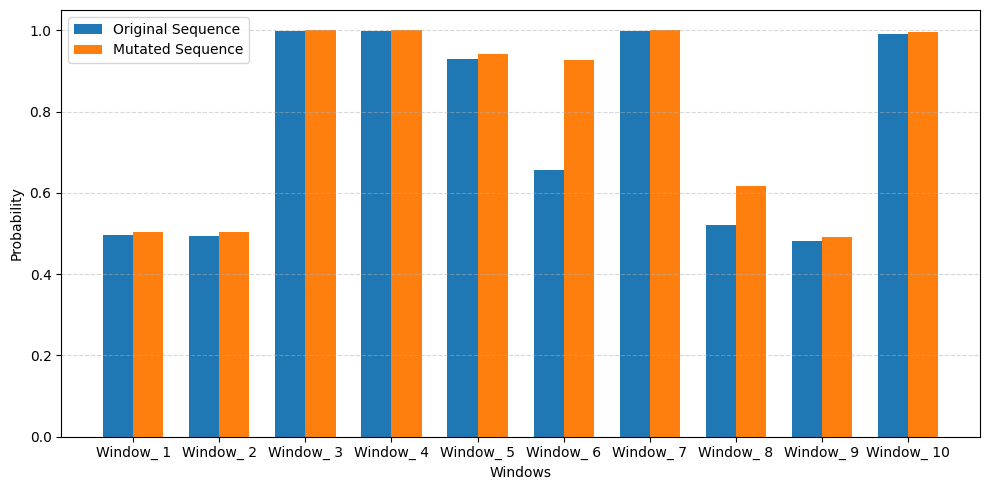

In [323]:
import matplotlib.pyplot as plt
import numpy as np

# 将这十个 list 放到一个大列表里
seq_check_vals = [
    seq_check_1_val, seq_check_2_val, seq_check_3_val, seq_check_4_val,
    seq_check_5_val, seq_check_6_val, seq_check_7_val, seq_check_8_val,
    seq_check_9_val, seq_check_10_val
]

# 转成 NumPy 数组，方便切片
data = np.array(seq_check_vals)   # shape = (10, 2)

# x 轴：10 个分组
x = np.arange(1, data.shape[0] + 1)

# 每根柱子的宽度
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))

# 第一组柱：data[:,0]
ax.bar(x - width/2, data[:, 0], width, label='Original Sequence')

# 第二组柱：data[:,1]
ax.bar(x + width/2, data[:, 1], width, label='Mutated Sequence')

# 美化
ax.set_xlabel('Windows')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels([f'Window_ {i}' for i in x])
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()